Alanine dipeptide Boltzmann Generator
------
A simple example of how to train a Boltzmann generator on a small system by computing forces and energies in OpenMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import mdtraj as md
import matplotlib as mpl

In [2]:
import torch

In [3]:
from IPython.display import SVG

In [4]:
from bgtorch.nn.flow.base import Flow
from bgtorch.nn import DenseNet
from bgtorch.nn.flow import (
    SequentialFlow, 
    CouplingFlow, 
    AffineFlow, 
    SplitFlow,
    MergeFlow,
    InverseFlow, 
    SwapFlow
)
from bgtorch.nn.flow.transformer import AffineTransformer
from bgtorch.distribution.energy import Energy
from bgtorch.distribution.sampling import Sampler
from bgtorch.distribution import NormalDistribution
from bgtorch import BoltzmannGenerator
from bgtorch.nn.training import KLTrainer

In [5]:
from bgtorch.nn.flow.stochastic import MetropolisMCFlow, LangevinFlow

In [6]:
rcParams.update({'font.size': 16})

In [7]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

Ala2
---

In [8]:
def plot_2ala_ramachandran(traj, ax=None, weights=None):
    if ax==None:
        ax = plt.gca()
    

    if isinstance(weights, np.ndarray):
        ax.hist2d(md.compute_phi(traj)[1].reshape(-1), 
                  md.compute_psi(traj)[1].reshape(-1), 
                  bins=[np.linspace(-np.pi, np.pi, 64), np.linspace(-np.pi, np.pi, 64)],
                  norm=mpl.colors.LogNorm(),
                  weights=weights)
    else:
        ax.hist2d(md.compute_phi(traj)[1].reshape(-1), 
                  md.compute_psi(traj)[1].reshape(-1), 
                  bins=[np.linspace(-np.pi, np.pi, 64), np.linspace(-np.pi, np.pi, 64)],
                  norm=mpl.colors.LogNorm())
        
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\psi$')    

In [9]:
from openmmtools.testsystems import AlanineDipeptideVacuum

In [10]:
ala2 = AlanineDipeptideVacuum(constraints=None)

In [11]:
temperature = 1000
n_atoms = ala2.mdtraj_topology.n_atoms

In [12]:
from simtk import openmm, unit
INTEGRATOR_ARGS = (temperature*unit.kelvin, 
                   1.0/unit.picoseconds, 
                   1.0*unit.femtoseconds)

In [13]:
from bgtorch.distribution.energy.openmm import OpenMMEnergy, OpenMMEnergyBridge
ala2_omm_energy_bridge = OpenMMEnergyBridge(ala2.system, unit.nanometers, 
                                            openmm_integrator=openmm.LangevinIntegrator, 
                                            openmm_integrator_args=INTEGRATOR_ARGS)

ala2_omm_energy = OpenMMEnergy(3 * n_atoms, ala2_omm_energy_bridge)

In [14]:
from bgtorch.utils.train import linlogcut

class RegularizedEnergy(Energy):
    def __init__(self, energy_model, high_energy, max_energy):
        super().__init__(energy_model.dim)
        self.energy_model = energy_model
        self.high_energy = high_energy
        self.max_energy = max_energy            

    def _energy(self, x, temperature=None):
        U = self.energy_model.energy(x)
        U_reg = linlogcut(U, high_val=self.high_energy, max_val=self.max_energy)
        return U_reg
    
class AugmentedEnergy(Energy):
    def __init__(self, base_model, dim_augment=None):
        if dim_augment is None:
            dim_augment = base_model.dim
        super().__init__(base_model.dim + dim_augment)
        self.base_model = base_model
    
    def _energy(self, x, temperature=None):
        U = self.base_model.energy(x[:, :self.base_model.dim])
        K = 0.5 * (x[:, self.base_model.dim:] ** 2).sum(axis=1, keepdim=True)            
        return U + K

Load training data
---

In [15]:
ala2_pdb = md.load('./data/alanine-dipeptide.pdb').topology
training_data_traj = md.load('./data/ala2_1000K_train.xtc', top=ala2_pdb)

In [16]:
phi = md.compute_phi(training_data_traj)[1].reshape(-1)
psi = md.compute_psi(training_data_traj)[1].reshape(-1)

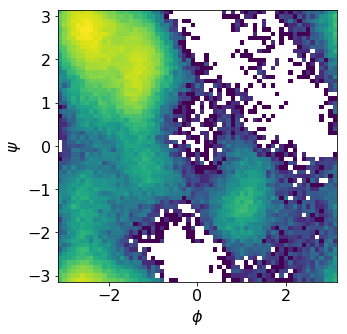

In [17]:
plt.figure(figsize=(5, 5))
plot_2ala_ramachandran(training_data_traj)

In [18]:
training_data = training_data_traj.xyz.reshape((training_data_traj.xyz.shape[0], 
                                                3*training_data_traj.xyz.shape[1]))
training_data = torch.tensor(training_data)
training_data.requires_grad = True

Internal Coordinates
---

In [19]:
for atom in ala2_pdb.atoms:
    print(atom)

ACE1-H1
ACE1-CH3
ACE1-H2
ACE1-H3
ACE1-C
ACE1-O
ALA2-N
ALA2-H
ALA2-CA
ALA2-HA
ALA2-CB
ALA2-HB1
ALA2-HB2
ALA2-HB3
ALA2-C
ALA2-O
NME3-N
NME3-H
NME3-C
NME3-H1
NME3-H2
NME3-H3


In [20]:
rigid_block = np.array([6, 8, 9, 10, 14])
Z = np.array([[0, 1, 4, 6],
              [1, 4, 6, 8],
              [2, 1, 4, 0],
              [3, 1, 4, 0],
              [4, 6, 8, 14],
              [5, 4, 6, 8],
              [7, 6, 8, 4],
              [11, 10, 8, 6],
              [12, 10, 8, 11],
              [13, 10, 8, 11],
              [15, 14, 8, 16],
              [16, 14, 8, 6],
              [17, 16, 14, 15],
              [18, 16, 14, 8],
              [19, 18, 16, 14],
              [20, 18, 16, 19],
              [21, 18, 16, 19]])

In [21]:
from bgtorch.nn.flow.crd_transform.ic import MixedCoordinateTransform
mct = MixedCoordinateTransform(rigid_block, Z, X0=training_data, remove_dof=6)

Stochastic Flows
----

In [22]:
class ICEnergy(object):
    def __init__(self, crd_transform, molecular_energy, use_jacobian=False):
        """ Single flow layer that does a BD step """
        self.crd_transform = crd_transform
        self.molecular_energy = molecular_energy
        self.use_jacobian = use_jacobian

    def energy(self, ics):
        xyz, dlogp = self.crd_transform(ics)  # evaluate in flow direction
        E = self.molecular_energy.energy(xyz) + self.crd_transform.periodic_angle_loss
        if self.use_jacobian:
            E = E - dlogp
        return E

    def force(self, ics):
        xyz, dlogp = self.crd_transform(ics)  # evaluate in flow direction
        E = self.molecular_energy.energy(xyz) + self.crd_transform.periodic_angle_loss
        if self.use_jacobian:
            E = E - dlogp
        F = -torch.autograd.grad(E.sum(), ics)[0]
        return F

In [23]:
class InterpolatedEnergy(object):
    def __init__(self, energy_model_0, energy_model_1, lambda_):
        """ Single flow layer that does a BD step """
        self.energy_model_0 = energy_model_0
        self.energy_model_1 = energy_model_1
        self.lambda_ = lambda_

    def energy(self, X):
        return (1.0-self.lambda_) * self.energy_model_0.energy(X) + self.lambda_ * self.energy_model_1.energy(X)

    def force(self, X):
        return (1.0-self.lambda_) * self.energy_model_0.force(X) + self.lambda_ * self.energy_model_1.force(X)

Boltzmann Generator
-------

In [24]:
def RNVP(shift_nhidden, scale_nhidden,
         shift_activation=torch.nn.ReLU(), scale_activation=torch.nn.Tanh(), 
         shift_weight_scale=1.0, scale_weight_scale=1.0, 
         shift_bias_scale=0.0, scale_bias_scale=0.0, init_downscale=1.0):
    
    shift_transformation = None
    if shift_nhidden is not None:
        shift_transformation=DenseNet(shift_nhidden, activation=shift_activation, 
                                      weight_scale=shift_weight_scale, bias_scale=shift_bias_scale)            
    scale_transformation = None
    if scale_nhidden is not None:
        scale_transformation=DenseNet(scale_nhidden, activation=scale_activation, 
                                      weight_scale=scale_weight_scale, bias_scale=scale_bias_scale)
    transformer = AffineTransformer(shift_transformation=shift_transformation,
                                    scale_transformation=scale_transformation,
                                    init_downscale=init_downscale) 
    return CouplingFlow(transformer)

In [25]:
class WrapLeft(Flow):
    def __init__(self, leftflow):
        super().__init__()
        self.leftflow = leftflow

    def _forward(self, x1, x2, **kwargs):
        y1, dlogp = self.leftflow(x1)
        return y1, x2, dlogp
    
    def _inverse(self, x1, x2, **kwargs):
        y1, dlogp = self.leftflow(x1, inverse=True)
        return y1, x2, dlogp


In [26]:
def build_XV_RNVP_Metropolis(hamiltonian_prior, hamiltonian_target, molecular_energy, crd_transform, 
                            energy_model_0, energy_model_1,
                            n_transform, shift_nhidden, scale_nhidden, dim_x, dim_ic,
                            n_relax_z=10, stepsize_z=0.1, 
                            n_relax_x=50, stepsize_x=0.002, mass=1, gamma=10.0, kT=1.0, 
                            diffuse_at_0=False, diffuse_intermediate=True, diffuse_at_1=True):
    # here we aggregate all layers of the flow
    layers = []

    # Initial Langevin flow
    if diffuse_at_0:
        layers.append(MetropolisMCFlow(hamiltonian_prior, nsteps=n_relax_z, stepsize=stepsize_z))
    
    # split
    layers.append(SplitFlow(dim_ic))
    
    # RealNVP block
    for i in range(n_transform):
        # ic(x) -> v
        layers.append(RNVP(shift_nhidden, scale_nhidden, 
                           shift_activation=torch.nn.ReLU(), scale_activation=torch.nn.ReLU()))
        layers.append(SwapFlow())
        # v -> ic(x)
        layers.append(RNVP(shift_nhidden[::-1], scale_nhidden[::-1], 
                           shift_activation=torch.nn.ReLU(), scale_activation=torch.nn.ReLU()))
        layers.append(SwapFlow())

        # Langevin flow
        if diffuse_intermediate:
            # Merge, MC, Split
            layers.append(MergeFlow(dim_ic))
            
            lambda_ = i * 1.0/(n_transform-1)
            energy_model = InterpolatedEnergy(energy_model_0, energy_model_1, lambda_)
            layers.append(MetropolisMCFlow(energy_model, nsteps=n_relax_z, stepsize=stepsize_z))
            
            layers.append(SplitFlow(dim_ic))
        
    # add crd transform
    layers.append(WrapLeft(crd_transform))

    # Final Langevin flow before merge
    if diffuse_at_1:
        layers.append(LangevinFlow(molecular_energy, nsteps=n_relax_x, stepsize=stepsize_x, 
                                   mass=mass, gamma=gamma, kT=kT))
    
    # merge
    layers.append(MergeFlow(dim_x))
    
    # now define the flow as a sequence of all operations stored in layers
    flexflow = SequentialFlow(layers)
    bg = BoltzmannGenerator(hamiltonian_prior, flexflow, hamiltonian_target)
    
    return bg    

In [27]:
dim_x = 66
dim_v = 66
dim_ic = 60

In [28]:
# Reguarlize molecular energy
ala2_energy_reg = RegularizedEnergy(ala2_omm_energy, high_energy=500, max_energy=10000)

In [29]:
# Setup full prior and target distribution.
hamiltonian_prior = NormalDistribution(dim_ic + dim_x)
hamiltonian_target = AugmentedEnergy(ala2_energy_reg, dim_augment=dim_x)

In [30]:
# Setup Stochastic Flow components
energy_model_0 = hamiltonian_prior  # prior model is a Normal on the ICs only
energy_model_1 = ICEnergy(mct, ala2_energy_reg, use_jacobian=False)  # posterior model is IC-transformed OpenMM energy.

In [31]:
bg = build_XV_RNVP_Metropolis(hamiltonian_prior, hamiltonian_target, ala2_energy_reg, mct, 
                              energy_model_0, energy_model_1,
                              5, [dim_ic, 128, 128, 128, dim_v], [dim_ic, 128, 128, 128, dim_v], 
                              dim_x=dim_x, dim_ic=dim_ic,
                              n_relax_z=20, stepsize_z=0.1, 
                              n_relax_x=20, stepsize_x=0.002, mass=1, gamma=10.0, kT=1.0, 
                              diffuse_at_0=False, diffuse_intermediate=True, diffuse_at_1=False)

In [32]:
trainer = KLTrainer(bg, train_likelihood=True, train_energy=False,
                    optim = torch.optim.Adam(bg.parameters(), lr=1e-3))

In [33]:
batchsize = 128

In [34]:
# add velocities, only 60 dimensions.
xv_aligned = torch.cat([training_data, torch.zeros(training_data.shape[0], dim_x).normal_()], dim=1)

In [35]:
trainer.train(1000, data=xv_aligned, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=20)

1	NLL: -48.4679	
21	NLL: -51.5105	
41	NLL: -52.0141	
61	NLL: -53.1142	
81	NLL: -54.4816	
101	NLL: -54.9355	
121	NLL: -54.5678	
141	NLL: -54.5307	
161	NLL: -54.0902	
181	NLL: -53.5582	
201	NLL: -53.9053	
221	NLL: -53.6568	
241	NLL: -53.6560	
261	NLL: -54.2466	
281	NLL: -53.6887	
301	NLL: -54.0896	
321	NLL: -54.2746	
341	NLL: -53.7516	
361	NLL: -57.5751	
381	NLL: -54.1763	
401	NLL: -52.9791	
421	NLL: -54.1316	
441	NLL: -56.0911	
461	NLL: -53.3274	
481	NLL: -55.8705	
501	NLL: -53.0071	
521	NLL: -55.3959	
541	NLL: -56.9035	
561	NLL: -55.4860	
581	NLL: -53.9594	
601	NLL: -55.3819	
621	NLL: -54.9170	
641	NLL: -55.2599	
661	NLL: -55.5864	
681	NLL: -56.4897	
701	NLL: -54.8998	
721	NLL: -54.2062	
741	NLL: -56.4618	
761	NLL: -54.6318	
781	NLL: -56.6995	
801	NLL: -55.7290	
821	NLL: -55.9380	
841	NLL: -54.1841	
861	NLL: -55.2155	
881	NLL: -54.7161	
901	NLL: -55.6237	
921	NLL: -56.3180	
941	NLL: -55.9921	
961	NLL: -56.2976	
981	NLL: -55.3375	


Evaluate
----

Text(0.5,0,'Iterations')

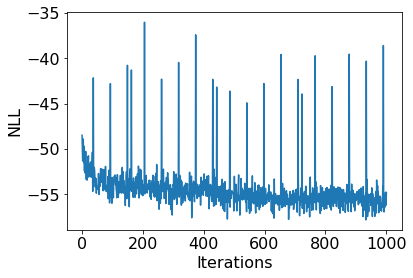

In [37]:
loss_names, x, ys = trainer.losses()
plt.plot(x, ys[0])
plt.ylabel(loss_names[0])
plt.xlabel('Iterations')

In [38]:
# sample
n_samples = 10000
z = hamiltonian_prior.sample(n_samples)
xgen, dW = bg.flow(z, temperature=1.0)

In [39]:
import mdtraj

torsions_train = mdtraj.compute_dihedrals(training_data_traj, mct.Z_indices)

gen_data_traj = mdtraj.Trajectory(xgen[:, :66].detach().reshape(-1, 22, 3).numpy(), ala2_pdb)
torsions_gen = mdtraj.compute_dihedrals(gen_data_traj, mct.Z_indices)

In [40]:
def periodic_convolution(x, kernel):
    x_padded = np.concatenate([x, x, x])
    y_padded = np.convolve(x_padded, kernel, mode='same')
    return y_padded[x.size:-x.size]

In [41]:
torsion_hists_train = []
torsion_hists_gen = []
xticks = None

for i in range(torsions_train.shape[1]):
    htrain, e = np.histogram(torsions_train[:, i], 50, range=(-np.pi, np.pi), density=True);
    xticks = 0.5 * (e[1:] + e[:-1])
    hgen, _ = np.histogram(torsions_gen[:, i], 50, range=(-np.pi, np.pi), density=True);
    
    htrain = periodic_convolution(htrain, [0.25, 0.5, 1.0, 0.5, 0.25])
    hgen = periodic_convolution(hgen, [0.25, 0.5, 1.0, 0.5, 0.25])
    
    torsion_hists_train.append(htrain)
    torsion_hists_gen.append(hgen)

In [42]:
torsions_simple = [4, 5, 6, 7, 8]
torsions_complex = [0, 1, 2, 10, 12]

Text(-2.84159,0.7,'RNVP + MCMC')

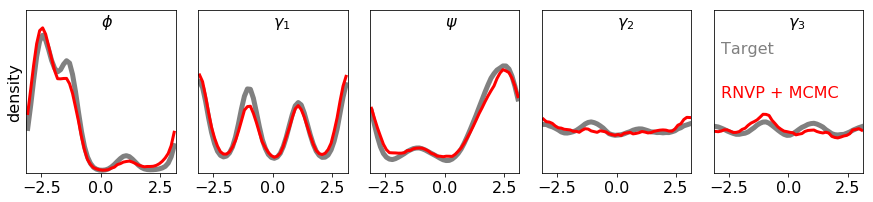

In [43]:
#fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(15, 5))
fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, sharex=True, figsize=(15, 3))
axes = axes.reshape((1, 5))
fig.subplots_adjust(hspace=0.05, wspace=0.15)
#for row, torsion_index in zip([0, 1], [torsions_simple, torsions_complex]):
for row, torsion_index in zip([0], [torsions_complex]):
    for i, ax in enumerate(axes[row]):
        ax.plot(xticks, torsion_hists_train[torsion_index[i]], color='grey', linewidth=5)
        ax.plot(xticks, torsion_hists_gen[torsion_index[i]], color='red', linewidth=3)
        ax.set_yticks([])
        ax.set_xlim(-np.pi, np.pi)
        if row == 0:
            ax.set_ylim(0, 5)
        if row == 1:
            ax.set_ylim(0, 1.5)
        if row == 1:
            ax.set_xticks((-np.pi,0, np.pi))
            ax.set_xticklabels(('$-\pi$', 0,'$\pi$'))
    axes[-1,-1].set_yticks([])
axes[0, 0].set_ylim(0, 1.5)
axes[0, 0].text(0, 1.35, '$\phi$')
axes[0, 1].text(0, 1.35, '$\gamma_1$')
axes[0, 2].text(0, 1.35, '$\psi$')
axes[0, 3].text(0, 1.35, '$\gamma_2$')
axes[0, 4].text(0, 1.35, '$\gamma_3$')
axes[0, 0].set_ylabel('density')
#axes[1, 0].set_ylabel('density')
axes[0, -1].text(-np.pi+0.3, 1.1, 'Target', color='grey')
axes[0, -1].text(-np.pi+0.3, 0.7, 'RNVP + MCMC', color='red')

In [44]:
eps = 1e-5
for i in torsions_complex:
    KL_SNF = np.sum(torsion_hists_train[i] * np.log((torsion_hists_train[i]+eps) / (torsion_hists_gen[i]+eps)))
    print("{:1.2f}".format(KL_SNF))

0.41
0.20
0.16
0.08
0.10
